# REPORT EXPLORATORY DATA ANALYSIS

For understanding the data properties and the feature engineering

## Load packages and data

In [1]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
root_dir = Path(os.getcwd()).resolve().parent
os.chdir(root_dir)
from utils.data_preparation import preprocess_data, split_data, mapping

plt.style.use('seaborn-v0_8-ticks')
sns.set_theme(style="ticks")

In [2]:
features = ['h_poly', 'h', 'GV1', 'GV3', 'GV51', 'MB4', 'MB8', 'MB10', 'MB18', \
            'P', 'T', 't', 'ln_t', 'Cos_s', 'Sin_s', 'Cos_2s', 'Sin_2s', 'month', 'year', \
            'h_MA_007', 'h_MA_014', 'h_MA_030', 'h_MA_060', 'h_RC_007', 'h_RC_030', 'T_MA_001', 'T_MA_007', 'T_MA_014', 'T_MA_030', 'T_MA_060',\
            'P_RS_030', 'P_RS_060', 'P_RS_090', 'P_RS_180']
target = 'h'
poly_degree = 4
start_date = "08-01-2020"
end_date = "03-01-2025"
# validation_size = 0.2
test_size = 0.2

X, y, dates = preprocess_data(features, target, start_date, end_date, poly_degree=poly_degree, \
                               test_size=test_size, validation_size=0)
    
X_train, X_test, y_train, y_test, split_index = split_data(X, y, test_size=test_size)
X_all = pd.concat([X_train, X_test])
print(f"Split index: {split_index}")
print(f"Dataset length: {len(X)}")

Split index: 32122
Dataset length: 40153


## Target distributions

In [3]:
def dist_plot(target: str):
    # Create a histogram of the total bill
    plt.figure(figsize=(8, 4))
    unit = 'MASL' if 'GV' or 'h' in target else 'L/s' if 'MB' in target else None
    if 'GV' in target:
        X_all[target] = X_all[target].replace(X_all[target].min(), np.nan)  # remove all interpolated values for valuable results
        data = X_all[target]
    else:
        data = X_all[target]
    if 'MB' in target:  # very tail heavy, thus necessary for many bins
        sns.histplot(data, bins=40, kde=True, color='blue')  # type: ignore
    else:
        sns.histplot(data, bins=20, kde=True, color='blue')  # type: ignore

    # Adding titles and labels
    if 'GV' in target:
        plt.title(f'Distribution of {target} (non-interpolated)', fontsize=16)  # specify that the interpolation has been removed
    else:
        plt.title(f'Distribution of {target}', fontsize=16)
    plt.xlabel(f'{target} ({unit})', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Show the plot
    plt.show()

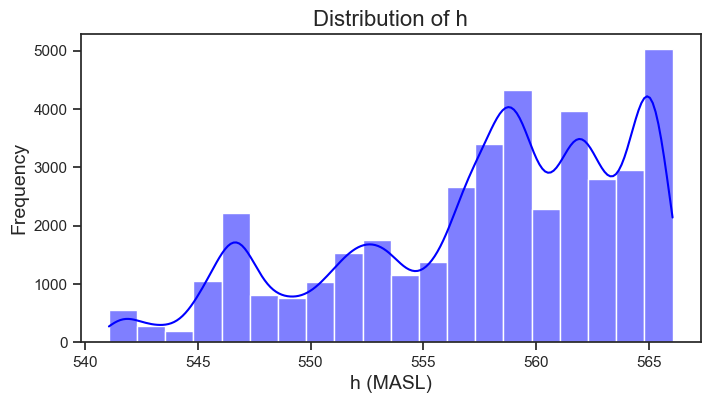

In [4]:
# Not a target but of interest
target = 'h'
dist_plot(target)


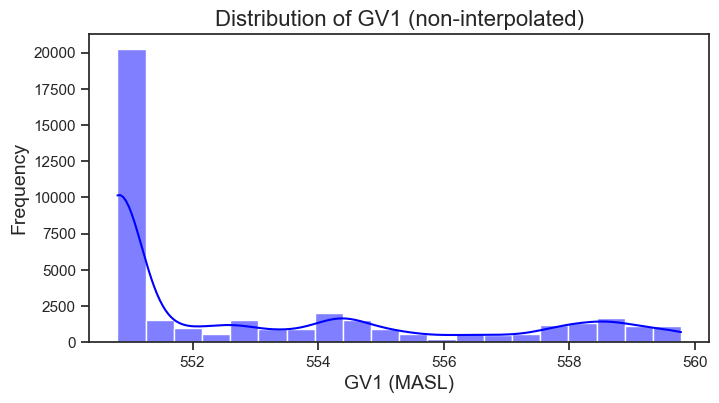

In [5]:
target = 'GV1'
dist_plot(target)

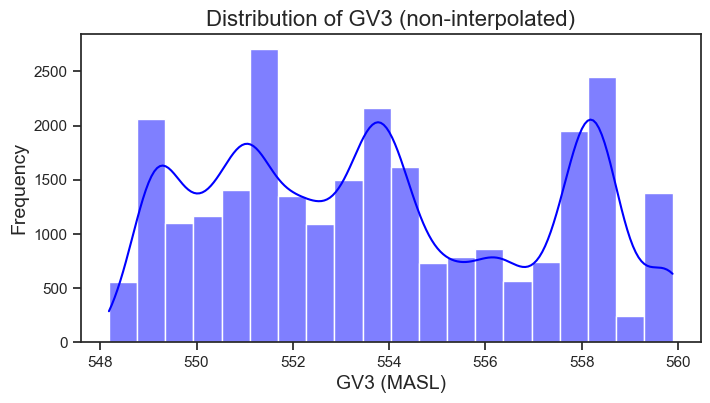

In [6]:
target = 'GV3'
dist_plot(target)

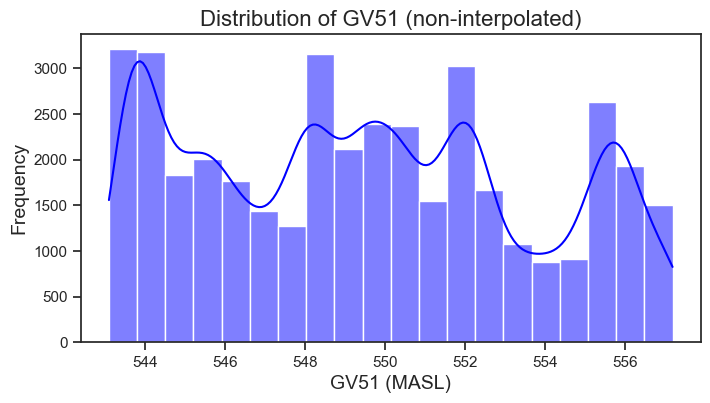

In [7]:
target = 'GV51'
dist_plot(target)

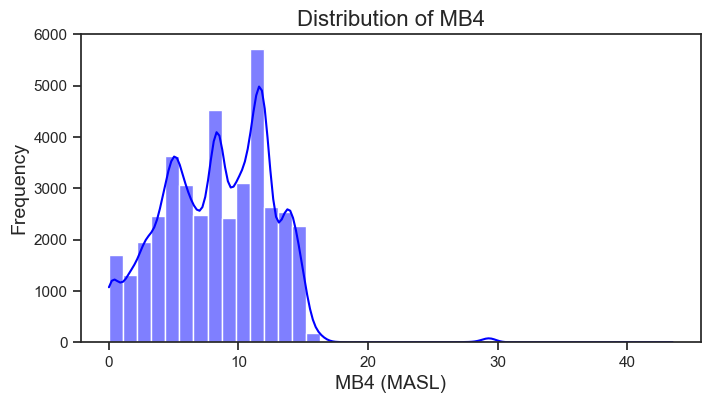

In [8]:
target = 'MB4'
dist_plot(target)

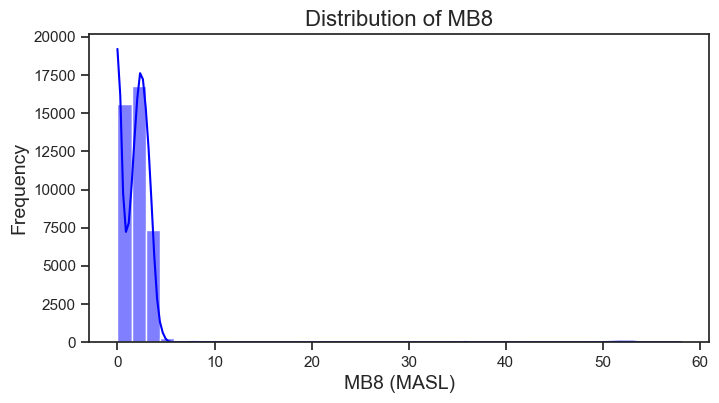

In [9]:
target = 'MB8'
dist_plot(target)

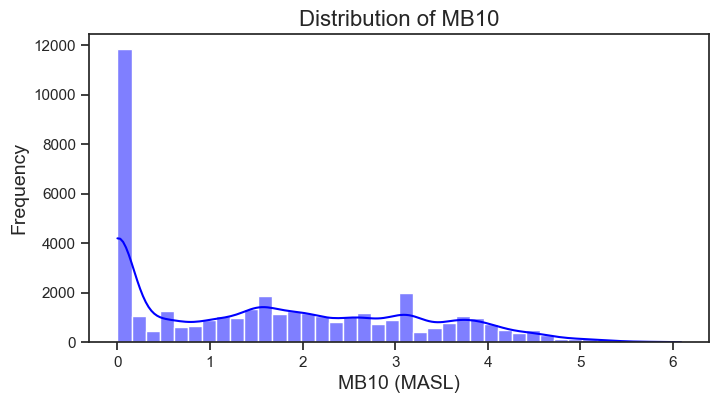

In [10]:
target = 'MB10'
dist_plot(target)

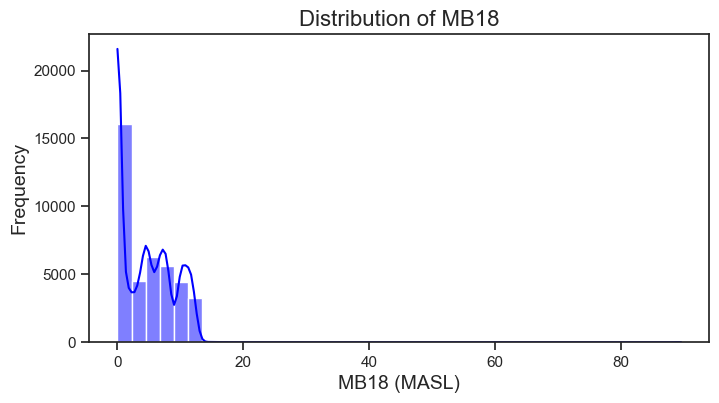

In [11]:
target = 'MB18'
dist_plot(target)


## Plots of derived features 
Sanity check to ensure that data leakage to test set has not occured (due to moving window calculations)

<Figure size 640x480 with 0 Axes>

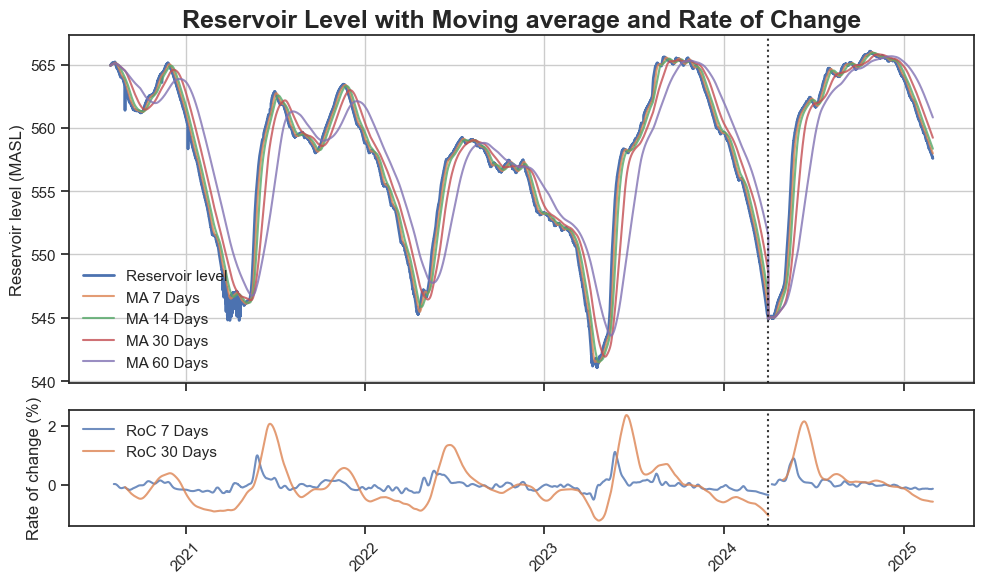

In [12]:
# Plotting all reservoir data
plt.clf()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)  

# Adding labels and title
ax1.set_title('Reservoir Level with Moving average and Rate of Change', fontsize=18, fontweight='bold')
ax1.plot(dates, X_all['h'], label='Reservoir level', linewidth=2)
ax1.plot(dates, X_all['h_MA_007'], label='MA 7 Days', alpha=.8)
ax1.plot(dates, X_all['h_MA_014'], label='MA 14 Days', alpha=.8)
ax1.plot(dates, X_all['h_MA_030'], label='MA 30 Days', alpha=.8)
ax1.plot(dates, X_all['h_MA_060'], label='MA 60 Days', alpha=.8)
ax1.axvline(x=dates.iloc[split_index], color='black', alpha=0.8, linestyle=':')
# ax1.axvline(x=dates.iloc[split_idx_test], color='black', alpha=0.8, linestyle=':')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Reservoir level (MASL)')
ax1.legend(loc='lower left')
ax1.grid(True)

ax2.plot(dates, X_all['h_RC_007'], label='RoC 7 Days', alpha=.8)
ax2.plot(dates, X_all['h_RC_030'], label='RoC 30 Days', alpha=.8)
ax2.axvline(x=dates.iloc[split_index], color='black', alpha=0.8, linestyle=':')
# ax2.axvline(x=dates.iloc[split_idx_test], color='black', alpha=0.8, linestyle=':')
ax2.set_ylabel('Rate of change (%)')
ax2.grid(True)
ax2.legend(loc='upper left')

# Show plot
plt.xticks(rotation=45)  
fig.tight_layout()  

plt.grid()
plt.show()

<Figure size 640x480 with 0 Axes>

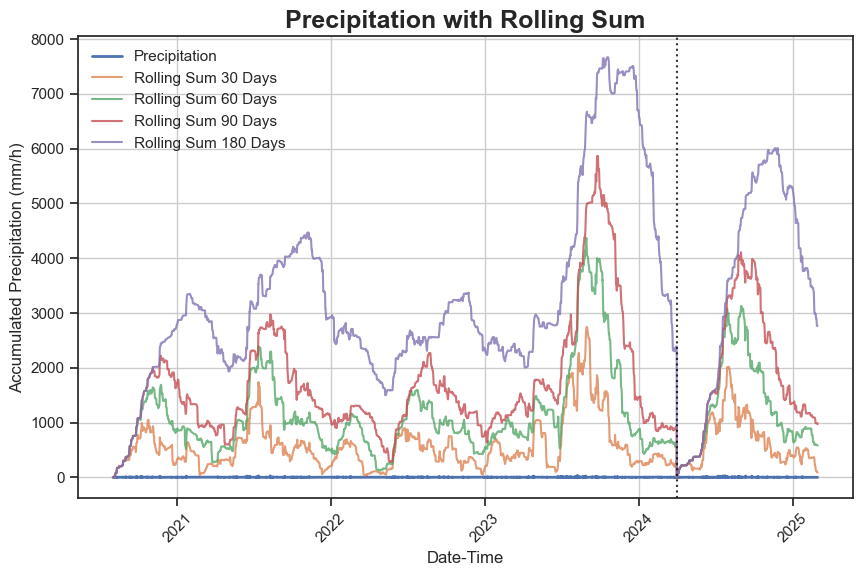

In [13]:
# Plotting all precipitation data
plt.clf()
plt.figure(figsize=(10, 6))

# Adding labels and title
plt.title('Precipitation with Rolling Sum', fontsize=18, fontweight='bold')
plt.plot(dates, X_all['P'], label='Precipitation', linewidth=2)
plt.plot(dates, X_all['P_RS_030'], label='Rolling Sum 30 Days', alpha=.8)
plt.plot(dates, X_all['P_RS_060'], label='Rolling Sum 60 Days', alpha=.8)
plt.plot(dates, X_all['P_RS_090'], label='Rolling Sum 90 Days', alpha=.8)
plt.plot(dates, X_all['P_RS_180'], label='Rolling Sum 180 Days', alpha=.8)
plt.axvline(x=dates.iloc[split_index], color='black', alpha=0.8, linestyle=':')
# plt.axvline(x=dates.iloc[split_idx_test], color='black', alpha=0.8, linestyle=':')
plt.xlabel('Date-Time')
plt.ylabel('Accumulated Precipitation (mm/h)')

# Show plot
plt.legend(loc='upper left')
plt.xticks(rotation=45)  
plt.grid()
plt.show()

<Figure size 640x480 with 0 Axes>

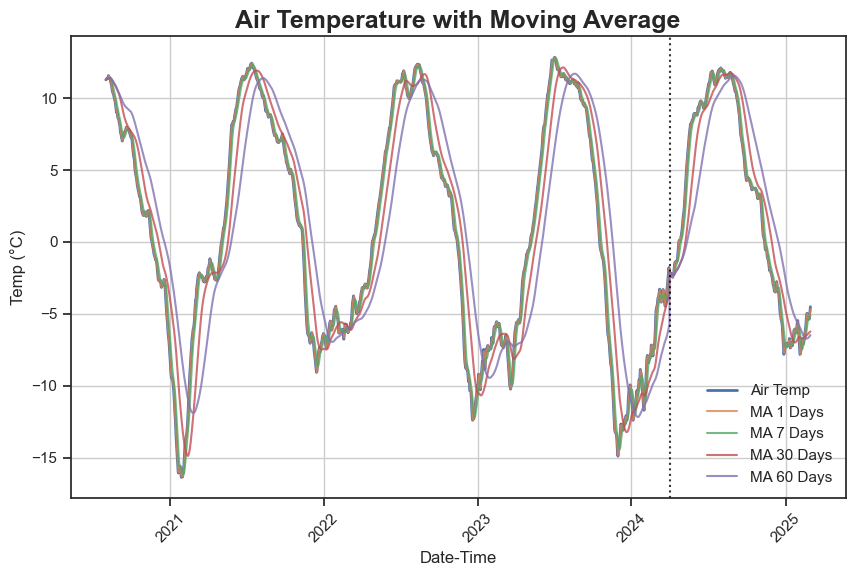

In [14]:
# Plotting all precipitation data
plt.clf()
plt.figure(figsize=(10, 6))

# Adding labels and title
plt.title('Air Temperature with Moving Average', fontsize=18, fontweight='bold')
plt.plot(dates, X_all['T'], label='Air Temp', linewidth=2)
plt.plot(dates, X_all['T_MA_001'], label='MA 1 Days', alpha=.8)
plt.plot(dates, X_all['T_MA_007'], label='MA 7 Days', alpha=.8)
plt.plot(dates, X_all['T_MA_030'], label='MA 30 Days', alpha=.8)
plt.plot(dates, X_all['T_MA_060'], label='MA 60 Days', alpha=.8)
plt.axvline(x=dates.iloc[split_index], color='black', alpha=0.8, linestyle=':')
# plt.axvline(x=dates.iloc[split_idx_test], color='black', alpha=0.8, linestyle=':')
plt.xlabel('Date-Time')
plt.ylabel('Temp (°C)')

# Show plot
plt.legend(loc='lower right')
plt.xticks(rotation=45)  
plt.grid()
plt.show()

## Time series decomposition

In [15]:
def plot_components(result):
    # Combine all the components into a DataFrame
    df = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis=1)
    df = df.rename(columns={'observed': 'Original Data', 'seasonal': 'Seasonal', 'trend': 'Trend', 'resid': 'Residual'})

    components = df.columns
    rows = len(components)

    # Create subplots with the appropriate number of rows
    fig, axes = plt.subplots(rows, 1, figsize=(10, 2 * rows), sharex=True)

    # In case we have only one component, axes is not a list, so we need to handle that
    if rows == 1:
        axes = [axes]

    # Plot each component
    for i, col in enumerate(components):
        axes[i].plot(df.index, df[col], label=col, color='tab:blue' if col == 'Original Data' else 'tab:orange')
        axes[i].set_title(col)
        axes[i].legend(loc='lower right')
        axes[i].set_ylabel(col)
        axes[i].grid()

    # Set the labels and title for the entire figure
    plt.xlabel('Time')
    fig.suptitle('Time Series Decompostion with STL', fontsize=22, weight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust the top to make room for the suptitle

    # Show the plot
    plt.show()

def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)

In [16]:
path = f'./data/LOS_DAMM_{mapping('h')}.csv'
data = pd.read_csv(path, sep=';', parse_dates=['Date-Time'])
data.set_index('Date-Time', inplace=True)
x_series = data[mapping('h')]

# Resample to daily average
h_daily_average = x_series.resample('D').mean()
print(h_daily_average)

Date-Time
2020-08-01    564.955000
2020-08-02    565.005417
2020-08-03    565.057083
2020-08-04    565.099167
2020-08-05    565.138750
                 ...    
2025-02-25    558.008750
2025-02-26    557.892417
2025-02-27    557.770583
2025-02-28    557.637417
2025-03-01    557.600000
Freq: D, Name: ÖVY, Length: 1674, dtype: float64


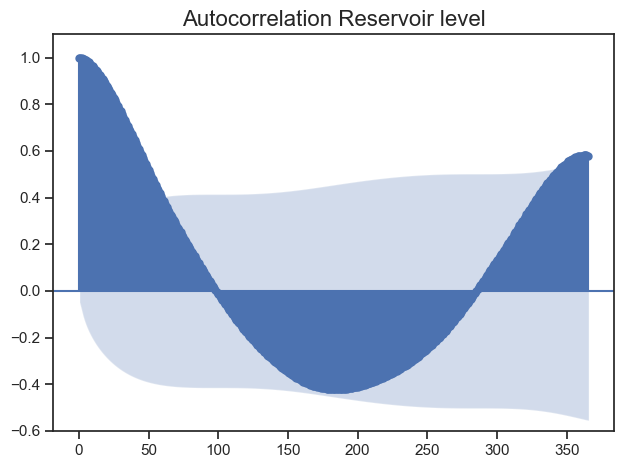

In [17]:
plot_acf(h_daily_average, lags=365)
plt.ylim(-0.6, 1.1)
plt.tight_layout()

# Adding titles and labels
plt.title('Autocorrelation Reservoir level', fontsize=16)
plt.show()


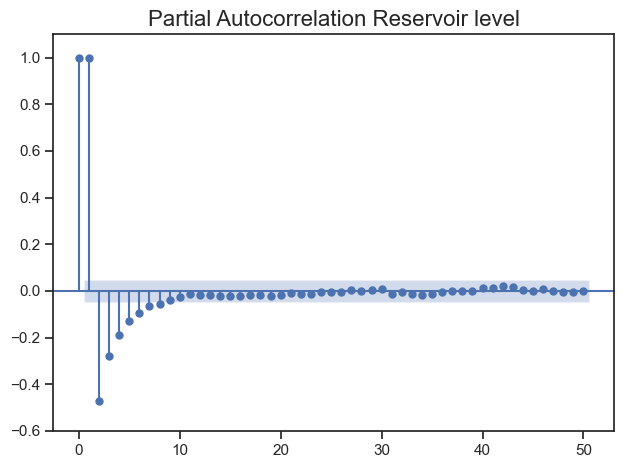

In [18]:
plot_pacf(h_daily_average, lags=50)
plt.ylim(-0.6, 1.1)
plt.tight_layout()

# Adding titles and labels
plt.title('Partial Autocorrelation Reservoir level', fontsize=16)
plt.show()

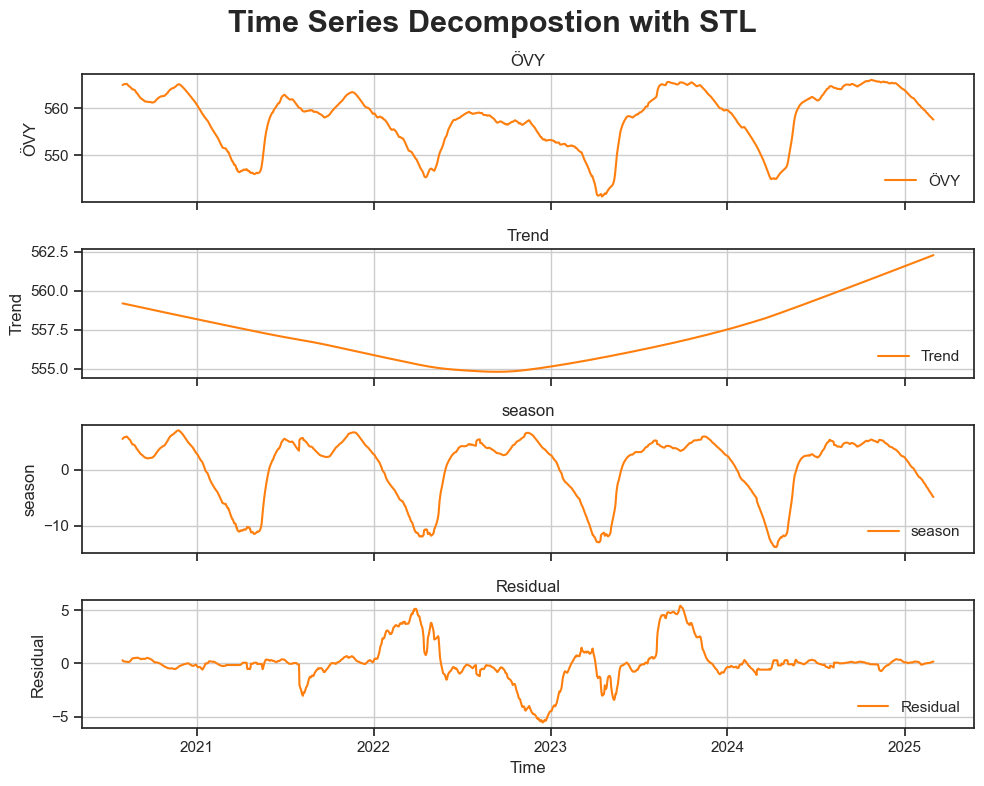

In [19]:
stl = STL(h_daily_average, period=365, robust=True)
result_stl = stl.fit()

# Plot the results
plot_components(result_stl)

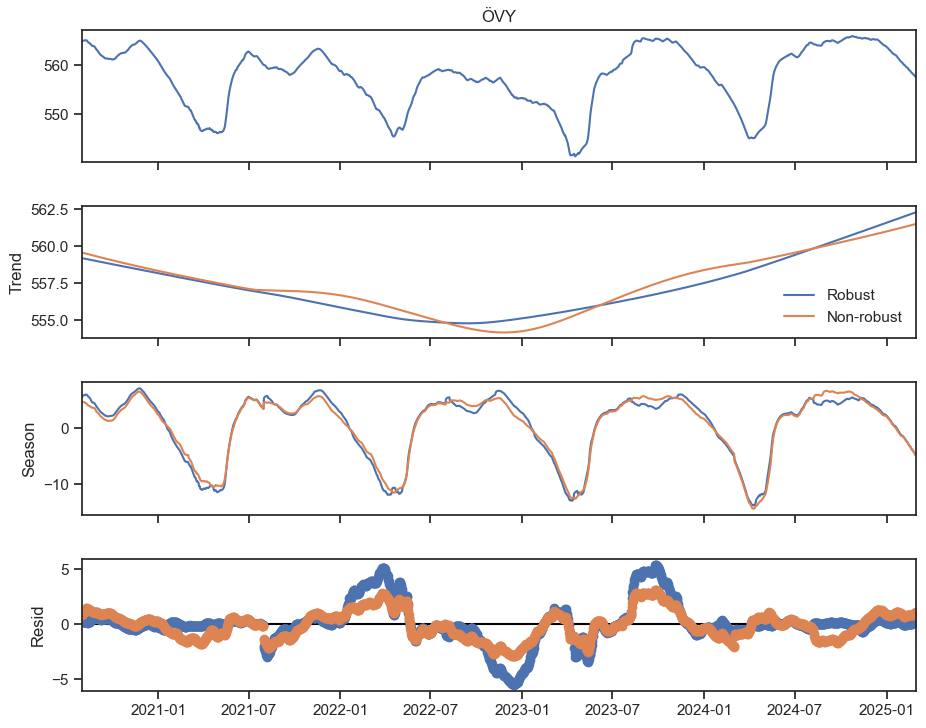

In [20]:
stl = STL(h_daily_average, period=365, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
fig.set_size_inches(10, 8)
res_non_robust = STL(h_daily_average, period=365, robust=False).fit()
add_stl_plot(fig, res_non_robust, ["Robust", "Non-robust"])

In [21]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform Ljung-Box test for up to 30 lags (one month)
# if lb_pvalue (p-val) is greater than 0.05, null hypothesis can be rejected
# and residuals can be considered non-stationary
lb_test = acorr_ljungbox(result_stl.resid, lags=30)
print(lb_test)


         lb_stat  lb_pvalue
1    1669.236138        0.0
2    3323.121133        0.0
3    4955.818400        0.0
4    6563.051628        0.0
5    8141.764239        0.0
6    9689.733916        0.0
7   11205.431308        0.0
8   12688.556961        0.0
9   14140.102366        0.0
10  15560.050338        0.0
11  16948.472347        0.0
12  18305.459059        0.0
13  19631.488946        0.0
14  20927.633444        0.0
15  22194.664349        0.0
16  23433.113956        0.0
17  24643.614878        0.0
18  25826.717306        0.0
19  26982.671035        0.0
20  28111.450965        0.0
21  29212.960358        0.0
22  30286.626319        0.0
23  31332.273507        0.0
24  32349.948533        0.0
25  33339.988441        0.0
26  34302.454413        0.0
27  35237.570299        0.0
28  36145.806583        0.0
29  37027.503977        0.0
30  37882.913574        0.0


In [22]:
path = f'./data/LOS_DAMM_{mapping('MB10')}.csv'
data = pd.read_csv(path, sep=';', parse_dates=['Date-Time'])
data.set_index('Date-Time', inplace=True)
x_series = data[mapping('MB10')]

# Resample to daily average
MB10_daily_average = x_series.resample('D').mean()

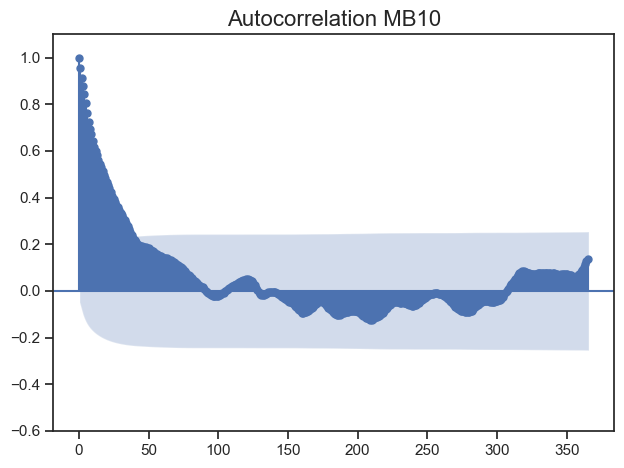

In [23]:
plot_acf(MB10_daily_average, lags=365)
plt.ylim(-0.6, 1.1)
plt.tight_layout()

# Adding titles and labels
plt.title('Autocorrelation MB10', fontsize=16)
plt.show()

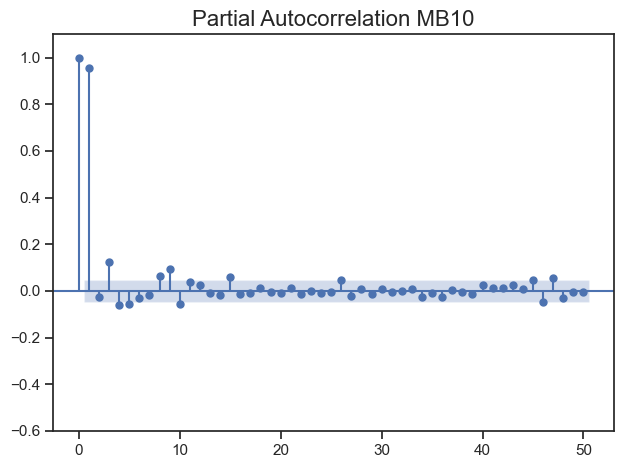

In [24]:
plot_pacf(MB10_daily_average, lags=50)
plt.ylim(-0.6, 1.1)
plt.tight_layout()

# Adding titles and labels
plt.title('Partial Autocorrelation MB10', fontsize=16)
plt.show()

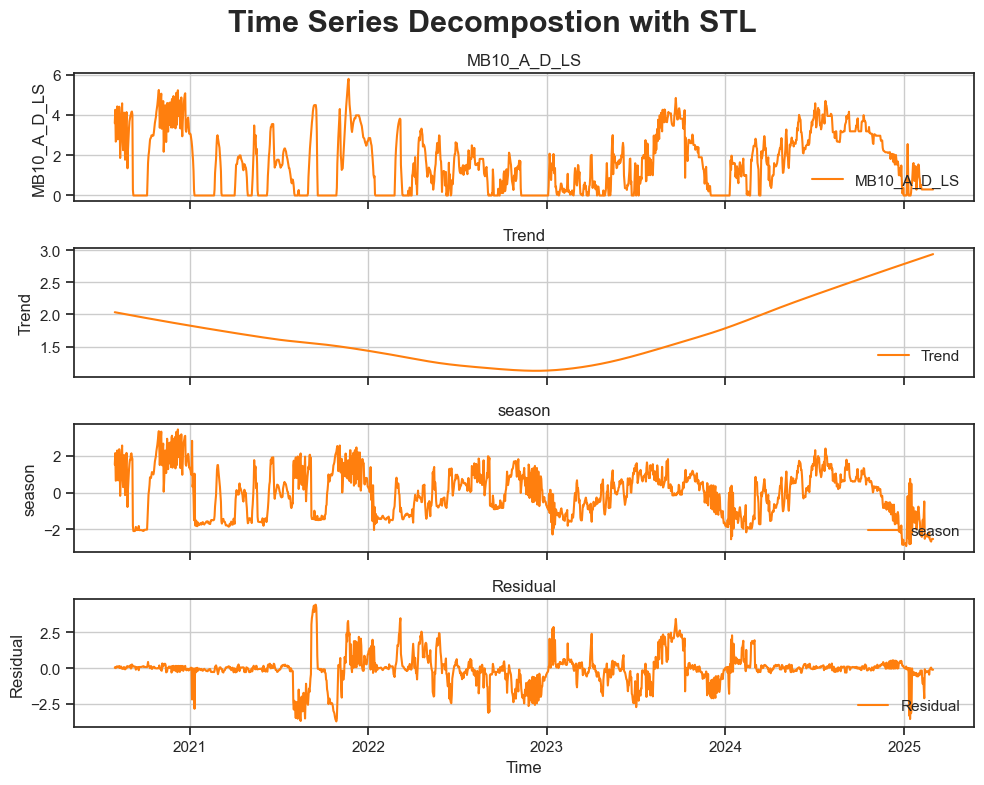

In [25]:
stl = STL(MB10_daily_average, period=365, robust=True)
result_stl = stl.fit()

# Plot the results
plot_components(result_stl)

In [26]:
path = f'./data/LOS_DAMM_{mapping('MB8')}.csv'
data = pd.read_csv(path, sep=';', parse_dates=['Date-Time'])
data.set_index('Date-Time', inplace=True)
x_series = data[mapping('MB8')]

# Resample to daily average
MB8_daily_average = x_series.resample('D').mean()

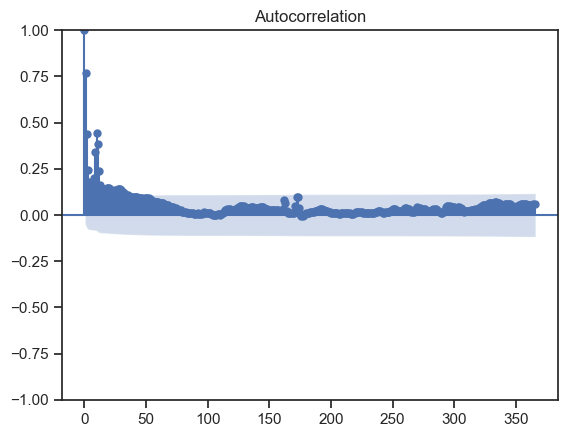

In [27]:
plot_acf(MB8_daily_average, lags=365)
plt.show()

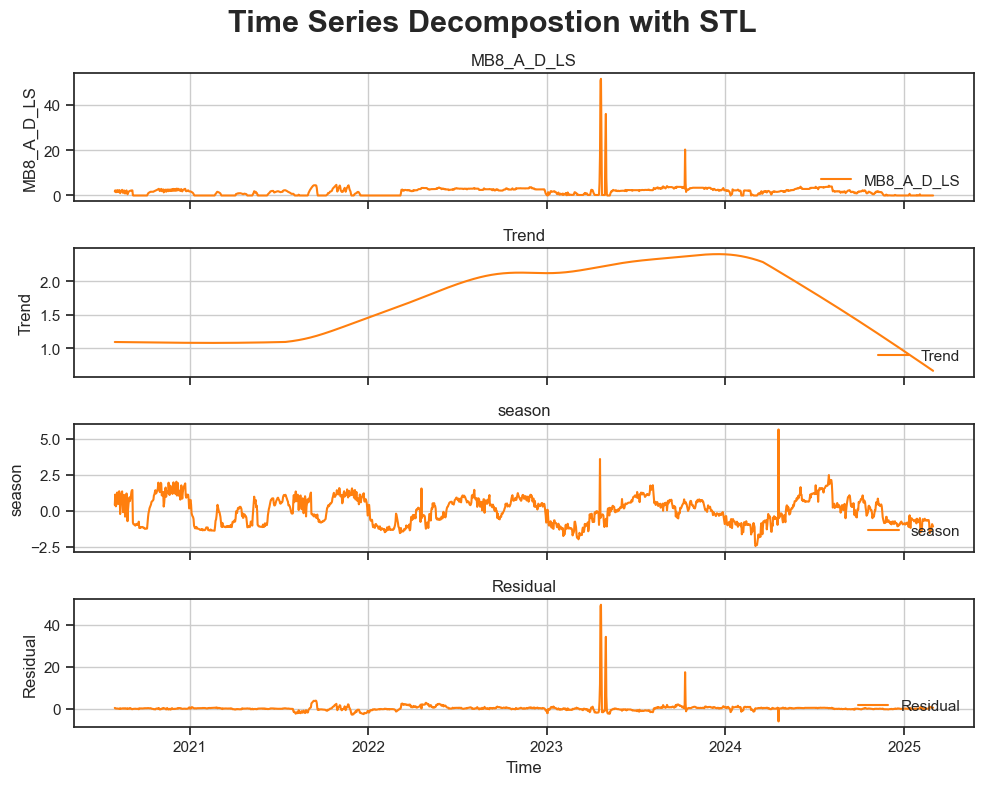

In [32]:
stl = STL(MB8_daily_average, period=365, robust=True)
result_stl = stl.fit()

# Plot the results
plot_components(result_stl)

## Correlation

In [33]:
pear_corr = X_train.corr(method='pearson')
pear_corr.style.background_gradient(cmap='Greens', axis=0)

,Sin_s,Cos_s,Sin_2s,Cos_2s,t,ln_t,month,year,h_poly_1,h_poly_2,h_poly_3,h_poly_4,h,GV1,GV3,GV51,MB4,MB8,MB10,MB18,P,T,h_MA_007,h_MA_014,h_MA_030,h_MA_060,h_RC_007,h_RC_030,T_MA_001,T_MA_007,T_MA_014,T_MA_030,T_MA_060,P_RS_030,P_RS_060,P_RS_090,P_RS_180
Sin_s,1.000000,0.037402,0.067171,0.036868,0.104195,0.194059,-0.780177,0.304984,-0.815925,-0.816309,-0.816657,-0.816970,-0.815925,-0.600635,-0.707278,-0.809827,-0.500093,-0.114282,-0.289155,-0.372699,-0.074350,-0.413939,-0.811726,-0.806128,-0.786629,-0.719802,-0.110100,-0.313942,-0.420985,-0.464776,-0.514453,-0.622437,-0.794857,-0.362166,-0.458059,-0.505298,-0.312632
Cos_s,0.037402,1.000000,-0.041571,0.070637,0.059619,0.057796,-0.012961,0.058461,0.014847,0.013936,0.013033,0.012137,0.014847,-0.007897,0.001363,0.071904,0.254757,-0.098926,-0.027986,-0.005805,-0.127675,-0.869831,0.059591,0.104429,0.206057,0.388660,-0.474407,-0.515116,-0.866726,-0.846674,-0.821278,-0.753006,-0.588899,-0.365507,-0.271331,-0.135541,0.242799
Sin_2s,0.067171,-0.041571,1.000000,-0.015454,0.025452,-0.059970,-0.441149,0.140675,0.031972,0.030435,0.028905,0.027380,0.031972,-0.038554,0.016678,0.077250,-0.030512,-0.177020,-0.125390,0.108697,0.037790,0.068447,0.070829,0.108055,0.181592,0.254029,-0.394903,-0.195431,0.067577,0.061772,0.054176,0.033923,-0.008101,0.151839,0.113784,0.026644,-0.056891
Cos_2s,0.036868,0.070637,-0.015454,1.000000,0.042538,0.068539,-0.010780,0.042769,0.298463,0.296323,0.294166,0.291991,0.298463,-0.084935,-0.006660,0.085543,0.040354,-0.041196,0.006064,-0.113091,0.031925,-0.087803,0.288206,0.272903,0.220861,0.082807,0.183275,0.451266,-0.088717,-0.094209,-0.100301,-0.109987,-0.111147,0.021579,-0.066816,-0.100748,0.056152
t,0.104195,0.059619,0.025452,0.042538,1.000000,0.872000,-0.088304,0.964289,-0.129082,-0.129017,-0.128947,-0.128870,-0.129082,-0.069812,-0.069292,-0.056180,-0.102176,0.193282,-0.142402,-0.140490,0.043926,-0.170011,-0.127087,-0.126182,-0.127624,-0.140511,-0.017847,0.027349,-0.170616,-0.174501,-0.178684,-0.188634,-0.205000,0.195241,0.265389,0.335404,0.589562
ln_t,0.194059,0.057796,-0.059970,0.068539,0.872000,1.000000,-0.132288,0.855120,-0.253682,-0.254547,-0.255404,-0.256253,-0.253682,-0.305519,-0.286228,-0.256737,-0.250096,0.151725,-0.232529,-0.361426,0.030118,-0.180486,-0.256863,-0.260958,-0.272566,-0.300405,0.030287,0.067509,-0.181580,-0.188493,-0.196272,-0.213535,-0.242491,0.167270,0.242302,0.314309,0.548275
month,-0.780177,-0.012961,-0.441149,-0.010780,-0.088304,-0.132288,1.000000,-0.348103,0.600593,0.601777,0.602932,0.604059,0.600593,0.519470,0.568203,0.611077,0.400852,0.170957,0.321338,0.238242,0.024365,0.276703,0.591429,0.582083,0.556203,0.477924,0.136526,0.312386,0.282236,0.316569,0.357872,0.454503,0.617873,0.172881,0.295250,0.380159,0.258097
year,0.304984,0.058461,0.140675,0.042769,0.964289,0.855120,-0.348103,1.000000,-0.280892,-0.281140,-0.281376,-0.281598,-0.280892,-0.203232,-0.215848,-0.214900,-0.202765,0.136663,-0.218440,-0.195657,0.034739,-0.232460,-0.276536,-0.273169,-0.267818,-0.259403,-0.053679,-0.059225,-0.234503,-0.247272,-0.262215,-0.297319,-0.356189,0.137917,0.171568,0.214822,0.486059
h_poly_1,-0.815925,0.014847,0.031972,0.298463,-0.129082,-0.253682,0.600593,-0.280892,1.000000,0.999983,0.999931,0.999845,1.000000,0.721920,0.811188,0.908531,0.577560,0.028178,0.428777,0.462253,0.089711,0.330413,0.995278,0.983072,0.935505,0.804673,0.193234,0.536822,0.336493,0.373662,0.414587,0.500009,0.629629,0.435839,0.524142,0.534100,0.393882
h_poly_2,-0.816309,0.013936,0.030435,0.296323,-0.129017,-0.254547,0.601777,-0.281140,0.999983,1.000000,0.999983,0.999931,0.999983,0.725405,0.814101,0.910432,0.579397,0.029562,0.431083,0.464654,0.090102,0.330997,0.995277,0.983112,0.935660,0.804996,0.192793,0.536420,0.337085,0.374306,0.415294,0.500829,0.630567,0.437678,0.526306,0.536299,0.394688


In [34]:
pear_corr = X_test.corr(method='pearson')
pear_corr.style.background_gradient(cmap='Greens', axis=0)

,Sin_s,Cos_s,Sin_2s,Cos_2s,t,ln_t,month,year,h_poly_1,h_poly_2,h_poly_3,h_poly_4,h,GV1,GV3,GV51,MB4,MB8,MB10,MB18,P,T,h_MA_007,h_MA_014,h_MA_030,h_MA_060,h_RC_007,h_RC_030,T_MA_001,T_MA_007,T_MA_014,T_MA_030,T_MA_060,P_RS_030,P_RS_060,P_RS_090,P_RS_180
Sin_s,1.000000,-0.051253,-0.098766,0.172064,-0.254397,-0.280930,-0.749959,0.386804,-0.809899,-0.812165,-0.814421,-0.816665,-0.809899,-0.969291,-0.914486,-0.915816,-0.841865,-0.053212,-0.569605,-0.903156,-0.100258,-0.376600,-0.804346,-0.799127,-0.785593,-0.745923,0.229350,0.133959,-0.384270,-0.431374,-0.484798,-0.596413,-0.767414,-0.598129,-0.803419,-0.929987,-0.793169
Cos_s,-0.051253,1.000000,-0.032547,0.045285,0.837110,0.829402,0.050769,0.538852,0.206777,0.207560,0.208341,0.209122,0.206777,0.214638,0.318443,0.256744,0.393283,-0.902681,-0.650214,0.268160,-0.161651,-0.893917,0.246624,0.285788,0.371835,0.518442,-0.537011,-0.723329,-0.890369,-0.867480,-0.838383,-0.763453,-0.595438,-0.501960,-0.326813,-0.090398,0.629453
Sin_2s,-0.098766,-0.032547,1.000000,0.076603,0.339780,0.340271,-0.349655,0.494330,0.188643,0.187389,0.186117,0.184827,0.188643,0.092430,0.184740,0.250858,0.185829,-0.066669,-0.098519,0.160783,0.087633,0.066933,0.222351,0.254816,0.319208,0.382110,-0.455028,-0.394828,0.068025,0.075532,0.083860,0.102902,0.106266,0.510838,0.511313,0.380579,0.153211
Cos_2s,0.172064,0.045285,0.076603,1.000000,0.220619,0.220621,-0.109996,0.233707,0.307440,0.305074,0.302688,0.300282,0.307440,-0.080600,0.081929,0.116250,0.179260,0.051962,-0.136614,0.066608,0.064468,-0.064199,0.309474,0.306375,0.282093,0.196603,-0.079007,0.252760,-0.064967,-0.070803,-0.079178,-0.108673,-0.184044,0.068801,-0.142510,-0.270899,-0.039908
t,-0.254397,0.837110,0.339780,0.220619,1.000000,0.999586,0.033896,0.660250,0.553336,0.552671,0.551992,0.551300,0.553336,0.366052,0.507099,0.539572,0.667914,-0.746409,-0.462827,0.471249,-0.082577,-0.632700,0.591489,0.627195,0.699172,0.802865,-0.644009,-0.781884,-0.628426,-0.601193,-0.569419,-0.493768,-0.350827,-0.125758,0.040792,0.209364,0.754426
ln_t,-0.280930,0.829402,0.340271,0.220621,0.999586,1.000000,0.054629,0.644417,0.575611,0.574989,0.574354,0.573704,0.575611,0.390560,0.529836,0.562792,0.688508,-0.735983,-0.440988,0.493983,-0.078202,-0.614100,0.613064,0.648069,0.718415,0.818936,-0.645146,-0.783195,-0.609654,-0.581391,-0.548485,-0.470684,-0.324923,-0.105329,0.064327,0.233962,0.770232
month,-0.749959,0.050769,-0.349655,-0.109996,0.033896,0.054629,1.000000,-0.725617,0.544631,0.547398,0.550165,0.552932,0.544631,0.758822,0.660256,0.629358,0.577904,0.055732,0.488448,0.677277,0.044603,0.271265,0.528600,0.514155,0.481027,0.427999,-0.017262,0.056004,0.277858,0.320287,0.365651,0.448874,0.582949,0.265346,0.424946,0.561748,0.561719
year,0.386804,0.538852,0.494330,0.233707,0.660250,0.644417,-0.725617,1.000000,-0.030148,-0.032656,-0.035174,-0.037700,-0.030148,-0.315742,-0.143690,-0.100820,0.025594,-0.552547,-0.684921,-0.184421,-0.091420,-0.639906,0.008303,0.044276,0.119193,0.230382,-0.422946,-0.513265,-0.641885,-0.654940,-0.666840,-0.676560,-0.678193,-0.286179,-0.291840,-0.278029,0.097755
h_poly_1,-0.809899,0.206777,0.188643,0.307440,0.553336,0.575611,0.544631,-0.030148,1.000000,0.999988,0.999954,0.999896,1.000000,0.811661,0.867590,0.937935,0.963780,-0.062469,0.340012,0.858140,0.089803,0.201854,0.996281,0.986664,0.953214,0.880774,-0.263632,-0.099691,0.208779,0.250217,0.293930,0.375783,0.488674,0.493018,0.625651,0.718178,0.793355
h_poly_2,-0.812165,0.207560,0.187389,0.305074,0.552671,0.574989,0.547398,-0.032656,0.999988,1.000000,0.999988,0.999954,0.999988,0.814263,0.869591,0.939313,0.964528,-0.062917,0.341023,0.860042,0.089748,0.201780,0.996363,0.986842,0.953581,0.881369,-0.264672,-0.100751,0.208729,0.250328,0.294247,0.376567,0.490240,0.493548,0.626758,0.719912,0.795121
